In [1]:
import torch

import numpy as np

from torchvision import models
from skimage import io, img_as_float, transform
from copy import deepcopy

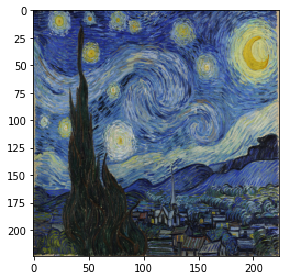

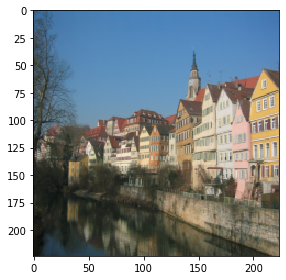

In [2]:
img_style = img_as_float(io.imread('./media/vangogh_starry_night.jpg'))
img_style = transform.resize(img_style, [224, 224])
img_content = img_as_float(io.imread('./media/Tuebingen_Neckarfront.jpg'))
img_content = transform.resize(img_content, [224, 224])

io.imshow(img_style)
io.show()
io.imshow(img_content)
io.show()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def to_tensor(img):
    tensor = torch.tensor(
        img.transpose(2, 0, 1)[None]
    )
    tensor -= torch.tensor([0.485, 0.456, 0.406])[None, ..., None, None]
    tensor /= torch.tensor([0.229, 0.224, 0.225])[None, ..., None, None]
    return tensor

def to_image(tensor):
    img = tensor[0].detach().cpu().numpy()
    img = img.transpose(1, 2, 0)
    img  *= np.array([0.229, 0.224, 0.225])[None, None]
    img  += np.array([0.485, 0.456, 0.406])[None, None]
    img = np.clip(img, 0, 1)
    return img


style_tensor = to_tensor(img_style).to(device).float()
content_tensor = to_tensor(img_content).to(device).float()

In [5]:

model = models.vgg16_bn(pretrained=True).to(device)

In [6]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [7]:
class ForwardHooks:
    def __init__(self):
        self.activation_dict = {}
    
    def get_hook(self, name):
        def hook(model, input, output):
            nonlocal self
            self.activation_dict[name] = output
        return hook
    
    

In [8]:
def content_loss_fn(activations1, activations2):
    return torch.mean((activations1 - activations2)**2)

def build_gramm_matrix(activation):
    _, c, w, h = activation.size()
    features = activation.view(c, w*h)
    G = torch.mm(features, features.t())
    return G.div(c * w * h)

def style_loss_fn(activations1, gramm_matix2):
    gramm_matix1 = build_gramm_matrix(activations1)
    return torch.mean((gramm_matix1 - gramm_matix2)**2)

In [9]:
def get_activations(inputs, hooks, activation_names):
    return [hooks.activation_dict[feature_name] for feature_name in activation_names]

In [10]:
hooks = ForwardHooks()
for name, module in model.named_modules():
    module.register_forward_hook(hooks.get_hook(name))

In [11]:
content_activation_names = ['features.32']
style_activation_names = ['features.36', 'features.26', 'features.2', 'features.9', 'features.16']

In [12]:
with torch.no_grad():
    _ = model(content_tensor)
    content_target_activations = get_activations(content_tensor, hooks, content_activation_names)
    _ = model(style_tensor)
    style_target_activations = get_activations(style_tensor, hooks, style_activation_names)
    style_target_gramm_matrixes = [
        build_gramm_matrix(activation) for activation in style_target_activations
    ]

0.003623277 0.021257197


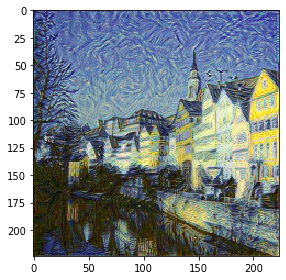

0.0028439127 0.004385859


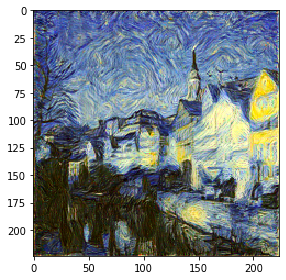

0.0027712632 0.004022832


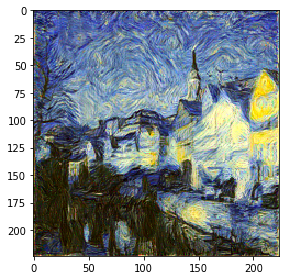

0.0027362928 0.0038901663


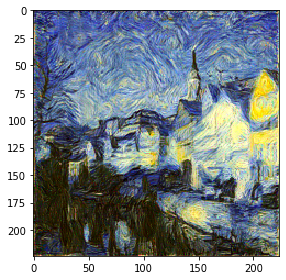

0.0027167618 0.0038210705


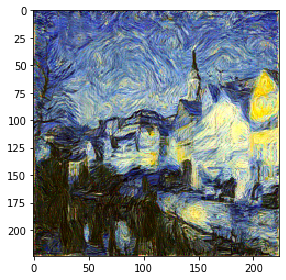

0.0027049473 0.0037773724


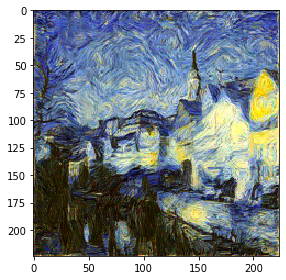

0.0026972238 0.00374706


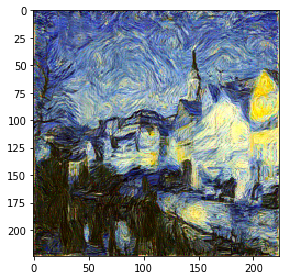

0.0026923327 0.0037224963


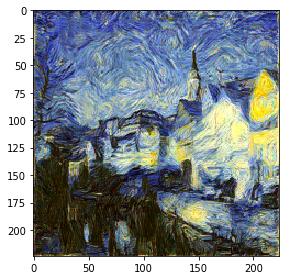

0.0026865066 0.0037059106


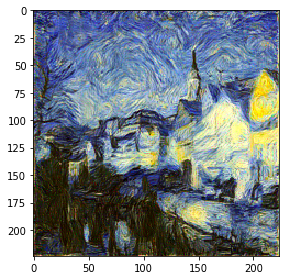

0.0026822393 0.0036919964


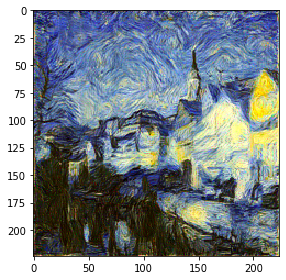

In [13]:
for param in model.parameters():
    param.requires_grad = False
    
    
optimization_tensor = content_tensor.clone().contiguous()
optimization_tensor.requires_grad=True
# optimization_tensor = torch.nn.Parameter(optimization_tensor)
optimizer = torch.optim.LBFGS([optimization_tensor])

content_weight = 1
style_weight = 1000000000
n_iters = 100
last_content_loss = None
last_style_loss = None
for i in range(n_iters):
    
    def closure():
        global last_content_loss
        global last_style_loss
        _ = model(optimization_tensor)
        content_activations = get_activations(optimization_tensor, hooks, content_activation_names)
        style_activations = get_activations(optimization_tensor, hooks, style_activation_names)

        content_losses = [
            content_loss_fn(activation1, activation2)
            for activation1, activation2 in zip(content_activations, content_target_activations)
        ]
        content_loss = sum(content_losses) * content_weight
        

        style_losses = [
            style_loss_fn(activation1, gramm2)
            for activation1, gramm2 in zip(style_activations, style_target_gramm_matrixes)
        ]
        style_loss = sum(style_losses) * style_weight
#         print(style_loss)

        loss = content_loss + style_loss
        
        last_content_loss = content_loss.detach().cpu().numpy()
        last_style_loss = style_loss.detach().cpu().numpy()
            
        optimizer.zero_grad()
        loss.backward()
        
        return loss
    optimizer.step(closure)
    if i % 10 == 0:
        print(last_content_loss, last_style_loss)
        io.imshow(to_image(optimization_tensor.detach().cpu()))
        io.show()